In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import requests
import json
import itertools
from pandas.io.json import json_normalize
import community
from networkx.algorithms.community import k_clique_communities

## INICIO DA COLETA DE DADOS

In [2]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    return categories_list[0]['name']

In [3]:
CLIENT_ID = '55LWIFZLZNZPSTAZZQKJXBD11BSBCUZTZPIXWVV4RFZJP1HS' # your Foursquare ID
CLIENT_SECRET = 'RPCOWGHQY5YNQUCHQUTC5VLKEYFGZN15FSIYTK5GNXNZ301E' # your Foursquare Secret
VERSION = '20180604'

In [4]:
latitude_nyork = 48.8534100
longitude_nyork = 2.3488000
radius = 5000
LIMIT = 100

In [7]:
QUERY = ''
url = 'https://api.foursquare.com/v2/venues/explore?time=any&query={}&client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(
    QUERY, CLIENT_ID, CLIENT_SECRET, latitude_nyork, longitude_nyork, VERSION, radius, LIMIT)
results = requests.get(url).json()
locais = results['response']['groups'][0]['items']
locais_proximos = json_normalize(locais)
filtered_columns = ['venue.id', 'venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
locais_proximos = locais_proximos.loc[:, filtered_columns]
locais_proximos.columns = [col.split(".")[-1] for col in locais_proximos.columns]
locais_proximos['categories'] = locais_proximos.apply(get_category_type, axis=1)
locais_proximos.tail(10)

,id,name,categories,lat,lng
90,4adcda21f964a520fc3921e3,La Grande Épicerie de Paris,Gourmet Shop,48.850322,2.323641
91,547efe8d498e129542045673,Dersou,Asian Restaurant,48.851418,2.374692
92,560ac500498e8ff36b2be81d,Hôtel Providence,Hotel,48.869283,2.356851
93,564387f4498ef77ac348d5c7,Nove,Italian Restaurant,48.852485,2.374268
94,4b7d8803f964a520dcc42fe3,Studio Harmonic,Dance Studio,48.853948,2.374654
95,4b30f9bbf964a5208ffd24e3,Jardin des Tuileries,Garden,48.863642,2.326484
96,4d38b652acf1b60c57ad8318,Le Chat Ivre,Tapas Restaurant,48.854991,2.374928
97,4b0ec8cdf964a520fb5a23e3,Max Linder Panorama,Indie Movie Theater,48.871487,2.344768
98,5581ba79498e2d654886dbad,Ober Mamma,Trattoria/Osteria,48.864507,2.370440
99,4cbdcb0b7148f04d510aefab,Pierre Hermé,Pastry Shop,48.868222,2.333397


In [8]:
checkins_locais = pd.DataFrame()
for i,local in locais_proximos.iterrows():
    url = 'https://api.foursquare.com/v2/venues/{}/likes?client_id={}&client_secret={}&v={}&limit={}'.format(
    local['id'], CLIENT_ID, CLIENT_SECRET, VERSION, 10000)
    results = requests.get(url).json()
    if (results['response']['likes']['count'] > 0) & ('items' in results['response']['likes']):
        results_2 = results['response']['likes']['items']
        checkins = json_normalize(results_2)[['id', 'firstName', 'gender']]
        checkins['avenue_id'] = local['id']
        checkins['avenue_name'] = local['name']
        checkins['avenue_categories'] = local['categories']
        checkins['avenue_lat'] = local['lat']
        checkins['avenue_lng'] = local['lng']
        if checkins_locais.empty:
            checkins_locais = checkins
        else:
            checkins_locais = pd.concat([checkins_locais, checkins], ignore_index=True)

In [9]:
checkins_locais.to_csv('victor_likes_paris_geral.csv', index=False)

In [10]:
checkins_locais.tail()

,id,firstName,gender,avenue_id,avenue_name,avenue_categories,avenue_lat,avenue_lng
61536,19489374,Nouf,female,4cbdcb0b7148f04d510aefab,Pierre Hermé,Pastry Shop,48.868222,2.333397
61537,4937078,Mélinda,female,4cbdcb0b7148f04d510aefab,Pierre Hermé,Pastry Shop,48.868222,2.333397
61538,1587945,Yann,male,4cbdcb0b7148f04d510aefab,Pierre Hermé,Pastry Shop,48.868222,2.333397
61539,35763424,Vladimir,male,4cbdcb0b7148f04d510aefab,Pierre Hermé,Pastry Shop,48.868222,2.333397
61540,12164265,Robert,male,4cbdcb0b7148f04d510aefab,Pierre Hermé,Pastry Shop,48.868222,2.333397


In [11]:
likes_value_counts = checkins_locais['avenue_id'].value_counts()
likes_value_value = likes_value_counts.index

In [12]:
likes = list(likes_value_value)

In [13]:
likes_completo = checkins_locais[checkins_locais['avenue_id'].isin(likes)]

In [14]:
likes_completo.tail()

,id,firstName,gender,avenue_id,avenue_name,avenue_categories,avenue_lat,avenue_lng
61536,19489374,Nouf,female,4cbdcb0b7148f04d510aefab,Pierre Hermé,Pastry Shop,48.868222,2.333397
61537,4937078,Mélinda,female,4cbdcb0b7148f04d510aefab,Pierre Hermé,Pastry Shop,48.868222,2.333397
61538,1587945,Yann,male,4cbdcb0b7148f04d510aefab,Pierre Hermé,Pastry Shop,48.868222,2.333397
61539,35763424,Vladimir,male,4cbdcb0b7148f04d510aefab,Pierre Hermé,Pastry Shop,48.868222,2.333397
61540,12164265,Robert,male,4cbdcb0b7148f04d510aefab,Pierre Hermé,Pastry Shop,48.868222,2.333397


In [15]:
vc = likes_completo['id'].value_counts()

In [20]:
filter = vc[vc >= 3].index.tolist()

In [21]:
usuarios_unicos = likes_completo[likes_completo['id'].isin(filter)]['id'].drop_duplicates()

In [22]:
usuarios_unicos = usuarios_unicos.tolist()

In [23]:
len(usuarios_unicos)

6082

In [24]:
grafo = nx.Graph()
for usuarios in usuarios_unicos:
    grafo.add_node(str(usuarios), 
           nome=likes_completo[likes_completo['id']==usuarios]['firstName'].values[0],
           genero=likes_completo[likes_completo['id']==usuarios]['gender'].values[0])
for u in usuarios_unicos:
    # locais que esta pessoa deu checkin...
    locais = list(likes_completo[likes_completo['id']==u]['avenue_id'].values)
    # outras pessoas que deram checkin nestes locais...
    outros_usuarios = list(likes_completo[
        (likes_completo['avenue_id'].isin(locais)) &
        (likes_completo['id'].isin(usuarios_unicos)) &
        (likes_completo['id'] != u)]['id'].values)
    for outro in outros_usuarios:
        if grafo.has_edge(str(u), str(outro)):
            grafo[str(u)][str(outro)]['weight'] = grafo[str(u)][str(outro)]['weight'] + 1
        else:
            grafo.add_edge(str(u), str(outro), weight=1)

In [25]:
pos = nx.spring_layout(grafo)

C:\Users\victorm\AppData\Local\Continuum\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


(-0.8349324174391433,
 0.996502361998151,
 -1.0924134507482544,
 0.766349220905249)

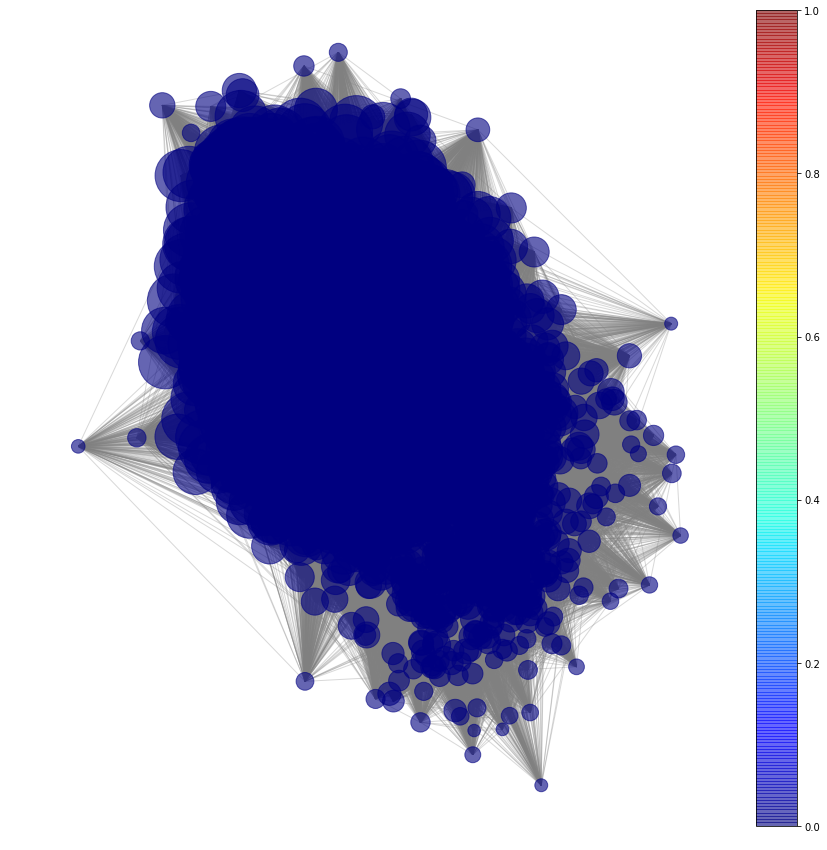

In [26]:
node_color = [0.0 for node in grafo.nodes()]
node_size = [grafo.degree(node) for node in grafo.nodes()]
plt.figure(figsize=(15,15))
ed = nx.draw_networkx_edges(grafo, pos=pos, alpha=0.3, edge_color='gray')
no = nx.draw_networkx_nodes(grafo, pos=pos, alpha=0.6, with_labels=False, node_color=node_color, 
                            cmap=cm.jet, vmin=0.0, vmax=1.0,
                            node_size=node_size)
plt.colorbar(no)
plt.axis('off')

(-0.8349324174391433,
 0.996502361998151,
 -1.0924134507482544,
 0.766349220905249)

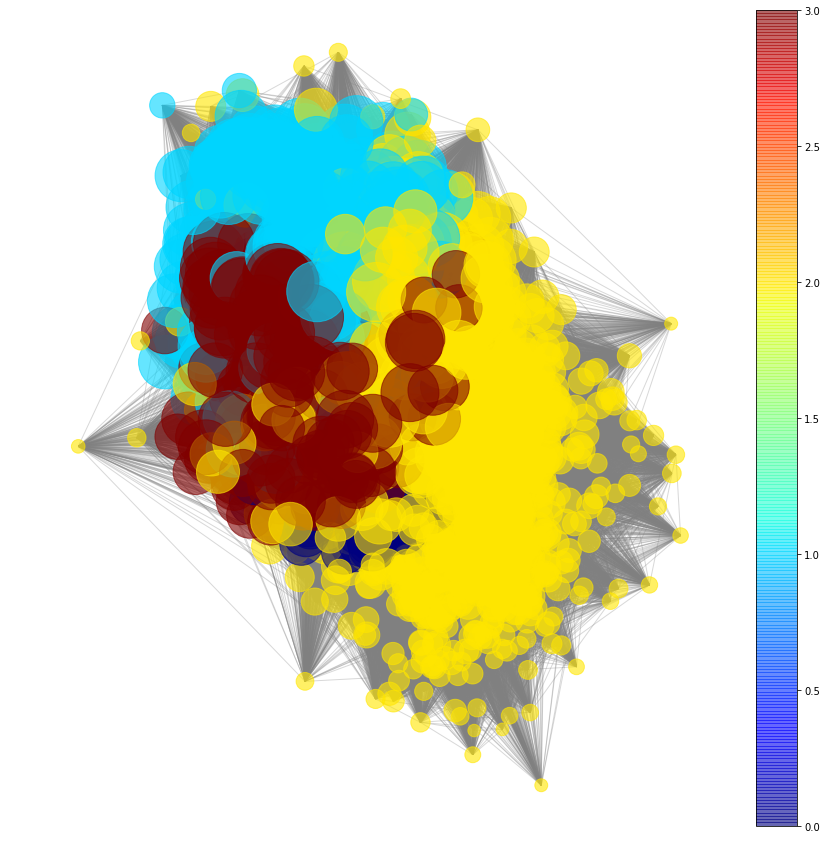

In [27]:
partition = community.best_partition(grafo, weight='weight')
node_color = [partition.get(node) for node in grafo.nodes()]
node_size = [grafo.degree(node) for node in grafo.nodes()]
plt.figure(figsize=(15,15))
ed = nx.draw_networkx_edges(grafo, pos=pos, alpha=0.3, edge_color='gray')
no = nx.draw_networkx_nodes(grafo, pos=pos, alpha=0.6, with_labels=False, node_color=node_color, 
                            cmap=cm.jet, vmin=0.0, vmax=max(partition.values()),
                            node_size=node_size)
plt.colorbar(no)
plt.axis('off')

In [28]:
likes_completo['cluster'] = likes_completo['id'].apply(lambda x: partition[x] if x in list(partition.keys()) else None) 

In [29]:
likes_com_cluster = likes_completo[~likes_completo['cluster'].isnull()]

In [30]:
likes_com_cluster[likes_com_cluster['cluster'] == 0]['avenue_name'].value_counts()[:5]

Centre Pompidou – Musée National d'Art Moderne    1454
Musée d'Orsay                                      655
Musée du Louvre                                    458
Cathédrale Notre-Dame de Paris                     458
Jardin du Luxembourg                               335
Name: avenue_name, dtype: int64

In [31]:
likes_com_cluster[likes_com_cluster['cluster'] == 1]['avenue_name'].value_counts()[:5]

Cathédrale Notre-Dame de Paris    1875
Musée du Louvre                   1834
Jardin des Tuileries               655
Jardin du Luxembourg               601
Panthéon                           397
Name: avenue_name, dtype: int64

In [32]:
likes_com_cluster[likes_com_cluster['cluster'] == 2]['avenue_name'].value_counts()[:5]

Jardin du Luxembourg         480
Le Bon Marché                477
Jardin des Tuileries         420
Marché des Enfants Rouges    329
L'As du Fallafel             313
Name: avenue_name, dtype: int64

In [33]:
likes_com_cluster[likes_com_cluster['cluster'] == 3]['avenue_name'].value_counts()[:5]

Musée d'Orsay                     683
Musée du Louvre                   219
Cathédrale Notre-Dame de Paris    207
Jardin des Tuileries              200
Jardin du Luxembourg              197
Name: avenue_name, dtype: int64